# Insiders Clustering Project

** Perguntas de Negócio **
1. Quem são os clientes elegíveis para participar do programa Insiders ?
2. Quantos clientes farão parte do grupo ?
3. Quais as principais características desses clientes ?
4. Qual o percentual de faturamento vinda do Insiders ?
5. Qual a expectativa de faturamento do Insiders para os próximos meses ?
6. Quais as condições para um cliente ser elegível ao Insiders ?
7. Quais as condições para um cliente ser removido do Insiders ?
8. Qual a garantia que o grupo Insiders é melhor que o restante da base ?
9. Quais ações o time de Marketing pode realizar para aumentar o faturamento ?

# 0.0 General Area

## 0.1 Imports

In [35]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import warnings
import re
import sqlite3
import pickle

from matplotlib import pyplot        as plt
from sklearn    import cluster       as c
from sklearn    import metrics       as m
from sklearn    import preprocessing as pp
from sklearn    import decomposition as dd
from sklearn    import ensemble      as en
from sklearn    import mixture       as mx
from sklearn.neighbors import NearestNeighbors
from plotly     import express       as px

from scipy.cluster       import hierarchy as hc
from sklearn.manifold    import TSNE
#from ydata_profiling     import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sqlalchemy          import create_engine

import umap.umap_ as umap

## 0.2 Support Functions

In [2]:
# data description functions
def numerical_attributes( df ):
    df_num_attributes = df.select_dtypes( include=['int64', 'float64'] )

    # Central Tendency - mean, median
    df_mean   = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
    df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T
    
    # Dispersion - min, max, range, std, skew, kurtosis
    df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
    df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
    df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
    df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
    df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate dataframes
    df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
    df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
    df_numerical
    
    return df_numerical

def categorical_attributes( df ):
    df_categorical = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

    return df_categorical

# data cleaning functions
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    df = df.rename( columns = {'customer' : 'customer_id' } )

    return df

# feature engineering functions
def feature_creation( df ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    
    
    return df

# data preparation functions
def rescaling_space( df ):
    mm = pp.MinMaxScaler()
    
    for column in df.columns:
        df[column] = mm.fit_transform( df[[column]] )
        pickle.dump( mm, open( '../parameters/' + column + '_scaler.pkl', 'wb' ) )

    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()
warnings.filterwarnings( 'ignore' )

## 0.3 Load Data

In [3]:
df_raw = pd.read_csv( '../data/Ecommerce.csv', low_memory=False, encoding='latin1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [5]:
print(f'Number of rows: { df1.shape[0] } ')
print(f'Number of cols: { df1.shape[1] } ')

Number of rows: 541909 
Number of cols: 9 


## 1.2 List Data Types

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

## 1.3 Descriptive Statistics

In [7]:
# identify and separate numerical and categorical attrributes
df_numerical   = numerical_attributes( df1 )
df_categorical = categorical_attributes( df1 )

### 1.3.1 Numerical Attributes

In [8]:
df_numerical.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,CustomerID,12346.00,18287.0,5941.00,15287.690570,NaN,1713.598197,0.029835,-1.179982
3,Unnamed: 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.2 Categorical Attributes

In [9]:
df_categorical.head()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,29-Nov-16,United Kingdom
1,536365,71053,WHITE METAL LANTERN,29-Nov-16,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,29-Nov-16,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,29-Nov-16,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,29-Nov-16,United Kingdom


# 2.0 Data Cleaning

In [10]:
df2 = df1.copy()

## 2.1 Rename Columns

In [11]:
df2 = rename_columns( df2 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,unnamed:8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


## 2.2 Drop Columns

In [12]:
df2 = df2.drop( 'unnamed:8', axis=1 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 2.3 Check N/A

In [13]:
# number of rows with NA values by column
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.4 Fillout N/A

### customer_id

In [14]:
#df2['customer_id'].max() = 1828

df_missing = df2[df2['customer_id'].isna()]
df_missing = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_missing['customer_id'] = np.arange( 1900, 1900+len( df_missing ), 1 )

df_missing.head()

,invoice_no,customer_id
622,536414,1900
1443,536544,1901
1970,536545,1902
1971,536546,1903
1972,536547,1904


In [15]:
# merging with missing customer_id dataframe
df2 = pd.merge( df2, df_missing, how='left', on='invoice_no' )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [16]:
# apply coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2 =df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [17]:
# re-check n/a values
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [18]:
df2[df2['description'].isna()].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
622,536414,22139,NaN,56,29-Nov-16,0.0,United Kingdom,1900.0
1970,536545,21134,NaN,1,29-Nov-16,0.0,United Kingdom,1902.0
1971,536546,22145,NaN,1,29-Nov-16,0.0,United Kingdom,1903.0
1972,536547,37509,NaN,1,29-Nov-16,0.0,United Kingdom,1904.0
1987,536549,85226A,NaN,1,29-Nov-16,0.0,United Kingdom,1905.0


## 2.6 Change Data Types

In [19]:
df2['invoice_date'] = pd.to_datetime( df2['invoice_date'] )
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id            float64
dtype: object

## 2.7 Remove Rows

### invoice_no

In [20]:
# identify invoice_no with letters
index = df2['invoice_no'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) )
df_letter_invoices =  df2.loc[ index, :] 
df_letter_invoices.head()

print(f'Total Number of Invoices with letters: { len( df_letter_invoices ) } ' )
print(f'Total Number of Invoices with letters and negative quantity: { len( df_letter_invoices[ df_letter_invoices["quantity"] < 0] ) } ' )

Total Number of Invoices with letters: 9291 
Total Number of Invoices with letters and negative quantity: 9288 


### stock_code

In [21]:
# identify stock_code with only letters
index = df2['stock_code'].apply( lambda x : bool( re.search( '^[a-zA-Z]+$', x ) ) )
df_letter_stock_code = df2.loc[ index, :] 

list_stock_code = df_letter_stock_code['stock_code'].unique()

print(f'List of removed stock code: { list_stock_code } ')
print(f'Rows removed: { len( df2[ df2["stock_code"].isin( list_stock_code ) ] ) } ' )

df2 = df2[ ~df2['stock_code'].isin( list_stock_code ) ]

List of removed stock code: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] 
Rows removed: 2759 


### unit_price

In [22]:
# removing rows when unit_price < 0.04
print(f'Rows removed: { len( df2[ df2["unit_price"] < 0.04] ) } ' )
df2 = df2[ df2['unit_price'] >= 0.04]

Rows removed: 2503 


### country

In [23]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [24]:
# removing rows where are no contries
print(f'Rows removed: { len( df2[ df2["country"].isin( ["European Community", "Unspecified"] ) ] ) } ' )
df2 = df2[ ~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

Rows removed: 504 


## 2.8 Separate original dataset in two: purchases and returns

In [25]:
df_returns   = df2[ df2['quantity'] < 0]
df_purchases = df2[ df2['quantity'] > 0]

print(f'Purchases dataset size: { len( df_purchases ) } ')
print(f'Returns dataset size: { len( df_returns ) } ')

Purchases dataset size: 527414 
Returns dataset size: 8729 


# 3.0 Feature Engineering

In [26]:
df3 = df_purchases.copy()

## 3.1 Feature Creation

In [27]:

def feature_creation( df, df_returns ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    

    # creating customer dataframe
    df_customer = df.drop( columns= ['invoice_no', 'stock_code', 'description', 'quantity', 
                                      'invoice_date', 'unit_price', 'country', 'gross_revenue'], axis=1).drop_duplicates( ignore_index=True )

    # creating customer monetary dataframe - amount of purchases
    df_monetary = df[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

    # creating customer frequency dataframe - number of purchases
    df_frequency = df[['customer_id', 'invoice_no']].groupby('customer_id').nunique().reset_index()

    # creating customer recency dataframe - number of days since last purchase
    max_invoice_date = df['invoice_date'].max()

    df_recency = df[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
    df_recency['recency_days'] =  ( max_invoice_date - df_recency['invoice_date'] ).dt.days
    df_recency = df_recency.drop( 'invoice_date', axis=1 )

    # creating average customer ticket dataframe
    df_avg_ticket = ( df[['customer_id', 'gross_revenue']]
                        .groupby('customer_id')
                        .mean()
                        .reset_index()
                        .rename( columns={ 'gross_revenue' : 'avg_ticket' } ) )

    # creating quantity products purchased dataframe
    df_prod_purchased = ( df[['customer_id', 'quantity']]
                         .groupby('customer_id')
                         .count()
                         .reset_index()
                         .rename( columns= {'quantity' : 'qtt_prod_purchased' } ) )

    # creating purchase frequency dataframe = qtt_purchases / range_days
    df_aux = ( df[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                .groupby( 'customer_id' )
                                                                .agg( max_ =  ( 'invoice_date', 'max' ),
                                                                      min_ =  ( 'invoice_date', 'min' ),
                                                                      days_ = ( 'invoice_date', lambda x : ( x.max() - x.min() ).days + 1),
                                                                      buys_ = ( 'invoice_no', 'count' ) ) ).reset_index()
    # calculate purchase frequency 
    df_aux['purchase_frequency'] = df_aux[['buys_', 'days_']].apply( lambda x : x['buys_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )
    df_purc_freq = df_aux[['customer_id', 'purchase_frequency']]

    # number of returns
    df_returns = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={ 'quantity' : 'qtt_returns' } )
    df_returns['qtt_returns'] = abs( df_returns['qtt_returns'] )

    # basket size - quantity
    df_bsize_quantity = ( df_purchases[['customer_id', 'invoice_no', 'quantity']]
                                .groupby('customer_id')
                                .agg( n_purchases=( 'invoice_no', 'nunique' ),
                                      n_products=( 'quantity', 'sum' ) )
                                .reset_index() )

    df_bsize_quantity['avg_bsize_quantity'] = df_bsize_quantity['n_products'] / df_bsize_quantity['n_purchases'] 
    df_bsize_quantity = df_bsize_quantity.drop( columns=['n_products', 'n_purchases'], axis=1 )

    # basket size - variety
    df_bsize_variety = ( df_purchases[['customer_id', 'invoice_no', 'stock_code']]
                                    .groupby('customer_id')
                                    .agg( n_purchases=( 'invoice_no', 'nunique' ),
                                          n_products=( 'stock_code', 'nunique' ) )
                                    .reset_index() )
    
    df_bsize_variety['avg_bsize_variety'] = df_bsize_variety['n_products'] / df_bsize_variety['n_purchases'] 
    df_bsize_variety = df_bsize_variety.drop( columns=['n_products', 'n_purchases'], axis=1)

    # merging customer dataframes
    df_customer = pd.merge( df_customer, df_recency,         how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_frequency,       how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_monetary,        how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_avg_ticket,      how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_prod_purchased,  how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_purc_freq,       how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_returns,         how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_bsize_quantity,  how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_bsize_variety,   how='left', on='customer_id' )

    df_customer.loc[ df_customer['qtt_returns'].isna(), 'qtt_returns'] = 0

    return df_customer
    

In [28]:
df3 = feature_creation( df3, df_returns )
df3.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,qtt_prod_purchased,purchase_frequency,qtt_returns,avg_bsize_quantity,avg_bsize_variety
0,17850.0,372,34,5391.21,18.152222,297,17.000000,40.0,50.970588,0.617647
1,13047.0,56,9,3232.59,18.904035,171,0.028302,35.0,154.444444,11.666667
2,12583.0,2,15,6705.38,28.902500,232,0.040323,50.0,335.200000,7.600000
3,13748.0,95,5,948.25,33.866071,28,0.017921,0.0,87.800000,4.800000
4,15100.0,333,3,876.00,292.000000,3,0.073171,22.0,26.666667,0.333333


In [29]:
df3.isna().sum()

customer_id           0
recency_days          0
invoice_no            0
gross_revenue         0
avg_ticket            0
qtt_prod_purchased    0
purchase_frequency    0
qtt_returns           0
avg_bsize_quantity    0
avg_bsize_variety     0
dtype: int64

# 4.0 Exploratory Data Analysis

In [30]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [31]:
#profile = ProfileReport(df4, title="EDA - Insiders Clustering")
#profile.to_file('eda_insiders_clustering_v_01.html')

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance

## 4.2 Bivariate Analysis

In [32]:
#df4_aux = df4.drop( ['customer_id'], axis=1 )

#plt.figure( figsize=(25,12) )
#sns.pairplot( df4_aux )

#df_viz = df9.drop( 'customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster');

## 4.3 Study of Space

In [39]:
# columns selected by business question
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtt_prod_purchased', 'purchase_frequency', 'qtt_returns']
df_space = df4[cols_selected].drop( columns='customer_id', axis=1 ).copy()

In [40]:
df_space.head()

,gross_revenue,recency_days,qtt_prod_purchased,purchase_frequency,qtt_returns
0,5391.21,372,297,17.000000,40.0
1,3232.59,56,171,0.028302,35.0
2,6705.38,2,232,0.040323,50.0
3,948.25,95,28,0.017921,0.0
4,876.00,333,3,0.073171,22.0


**Distribuições e os tipos de Preparação dos Dados**
1. Distribuição Normal e Não Possui Outlier -> Standard Scaler (média e desvio padrão)
2. Distribuição Normal e Possui Outlier     -> Robust Scaler (Quartis)
3. Não é uma Distribuição Normal            -> MinMax Scaler

* Padronização/Normalização (Standardization) -> Premissa que os dados vieram de uma distribuição normal
* Rescala -> Não há premissa de que os dados vieram de uma distribuição normal

**Testes de Normalidade**
1. QQ Plot -> Quantile Quantile Plot (quantile teórico x quantile real)
2. KS Test -> Kolgomorov Smirnoff (Teste de hipótese). Se p-valor > 0.5 então é Distribuição Normal, p-valor < 0.5 então NÃO é distribuição normal

**Detecção de Outliers**
1. Box Plot -> Pontos no gráfico identificam os outliers
2. Z-Score -> Se Z-Score > 3 ou Z-Score < -3 então é outlier

In [36]:
pwd

'/home/datamendes/comunidadeds/projetos/insiders_clustering/notebooks'

In [44]:
df_space = rescaling_space( df_space )
df_space.head()

,gross_revenue,recency_days,qtt_prod_purchased,purchase_frequency,qtt_returns
0,0.019312,0.997319,0.037770,1.000000,0.000494
1,0.011579,0.150134,0.021692,0.001345,0.000432
2,0.024020,0.005362,0.029476,0.002052,0.000617
3,0.003396,0.254692,0.003445,0.000734,0.000000
4,0.003137,0.892761,0.000255,0.003985,0.000272


In [38]:



#df_space['recency_days']       = mm.fit_transform( df_space[['recency_days']] )
#pickle.dump( mm, open( '../parameters/recency_days_scaler.pkl', 'wb' ) )

#df_space['gross_revenue']      = mm.fit_transform( df_space[['gross_revenue']] )
#pickle.dump( mm, open( '../parameters/recency_days_scaler.pkl', 'wb' ) )

#df_space['qtt_prod_purchased'] = mm.fit_transform( df_space[['qtt_prod_purchased']] )
#pickle.dump( mm, open( '../parameters/recency_days_scaler.pkl', 'wb' ) )

#df_space['purchase_frequency'] = mm.fit_transform( df_space[['purchase_frequency']] )
#pickle.dump( mm, open( '../parameters/recency_days_scaler.pkl', 'wb' ) )

#df_space['qtt_returns']        = mm.fit_transform( df_space[['qtt_returns']] )
#pickle.dump( mm, open( '../parameters/recency_days_scaler.pkl', 'wb' ) )

#df_space.head()

,gross_revenue,recency_days,qtt_prod_purchased,purchase_frequency,qtt_returns
0,0.019312,0.997319,0.037770,1.000000,0.000494
1,0.011579,0.150134,0.021692,0.001345,0.000432
2,0.024020,0.005362,0.029476,0.002052,0.000617
3,0.003396,0.254692,0.003445,0.000734,0.000000
4,0.003137,0.892761,0.000255,0.003985,0.000272


In [45]:
df_space.shape

(5696, 5)

### 4.3.1 PCA

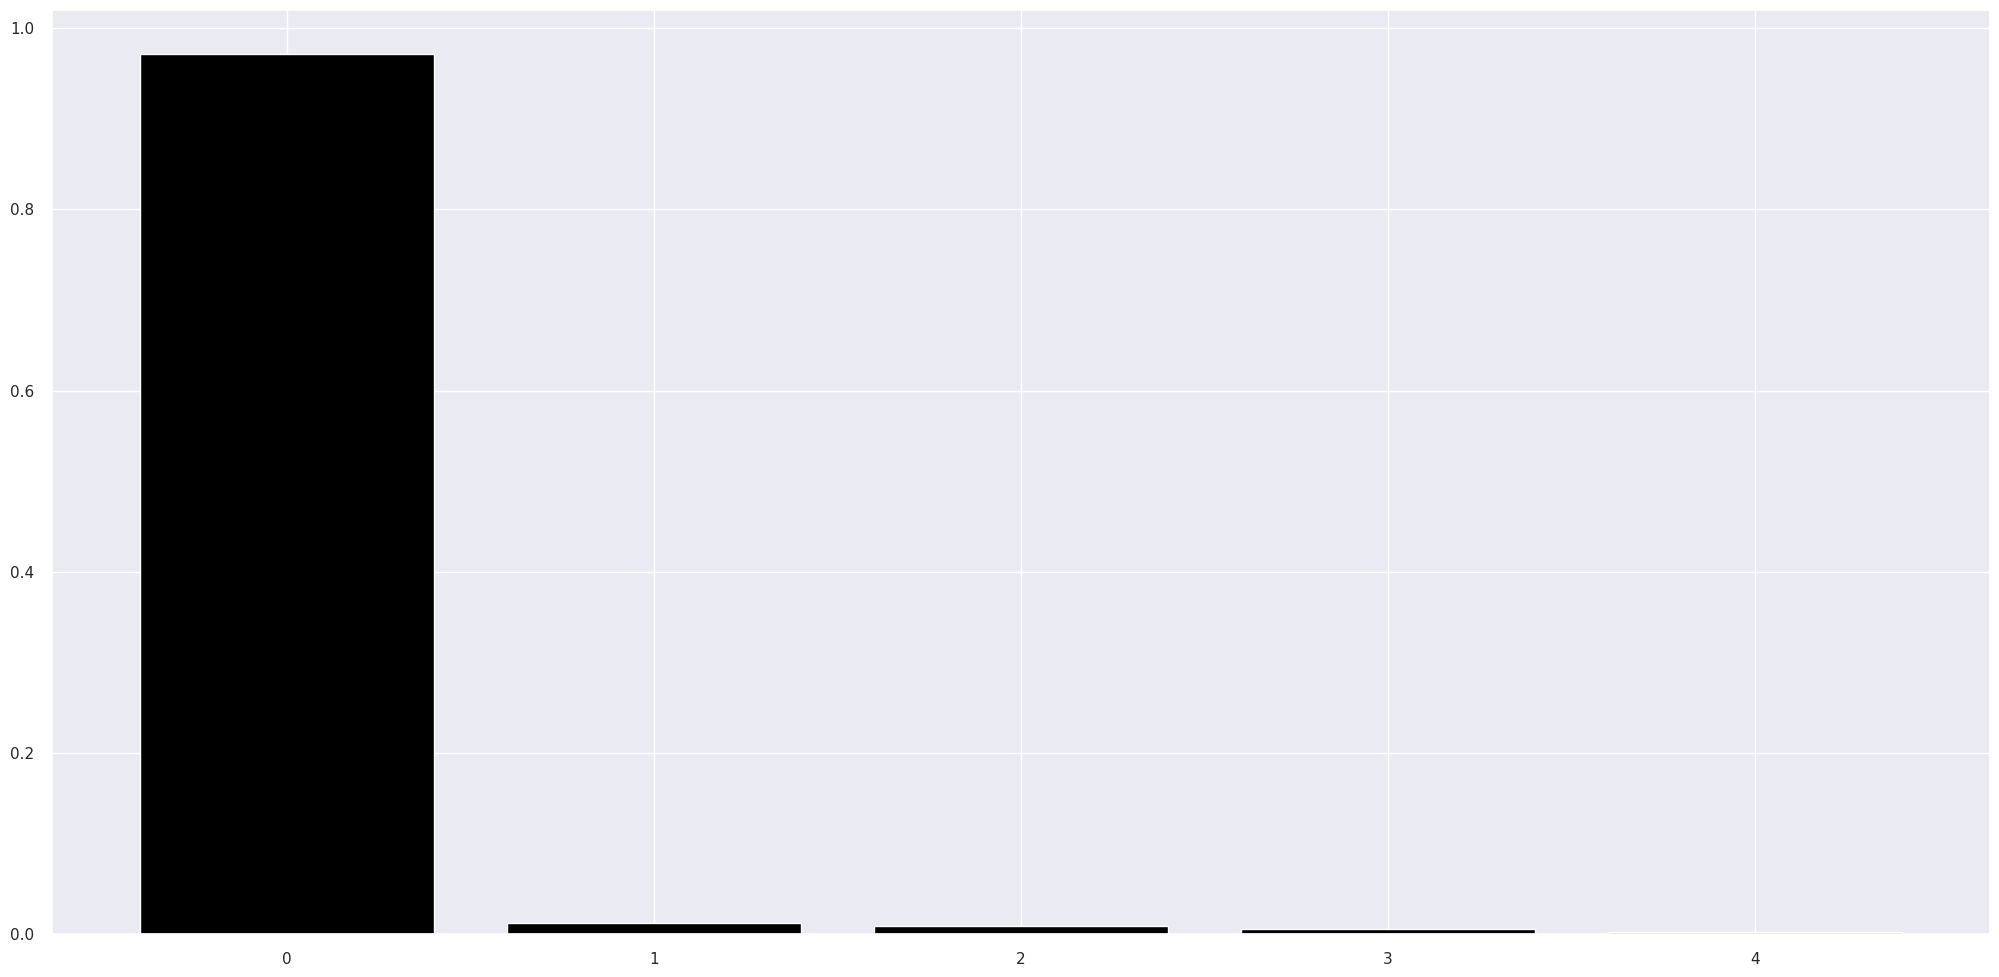

In [46]:
# PCA defined by numers of features
pca = dd.PCA( n_components=df_space.shape[1] )
principal_components = pca.fit_transform( df_space )

# plot explained variable
features = range( pca.n_components_ )
plt.bar( features, pca.explained_variance_ratio_, color='black' );


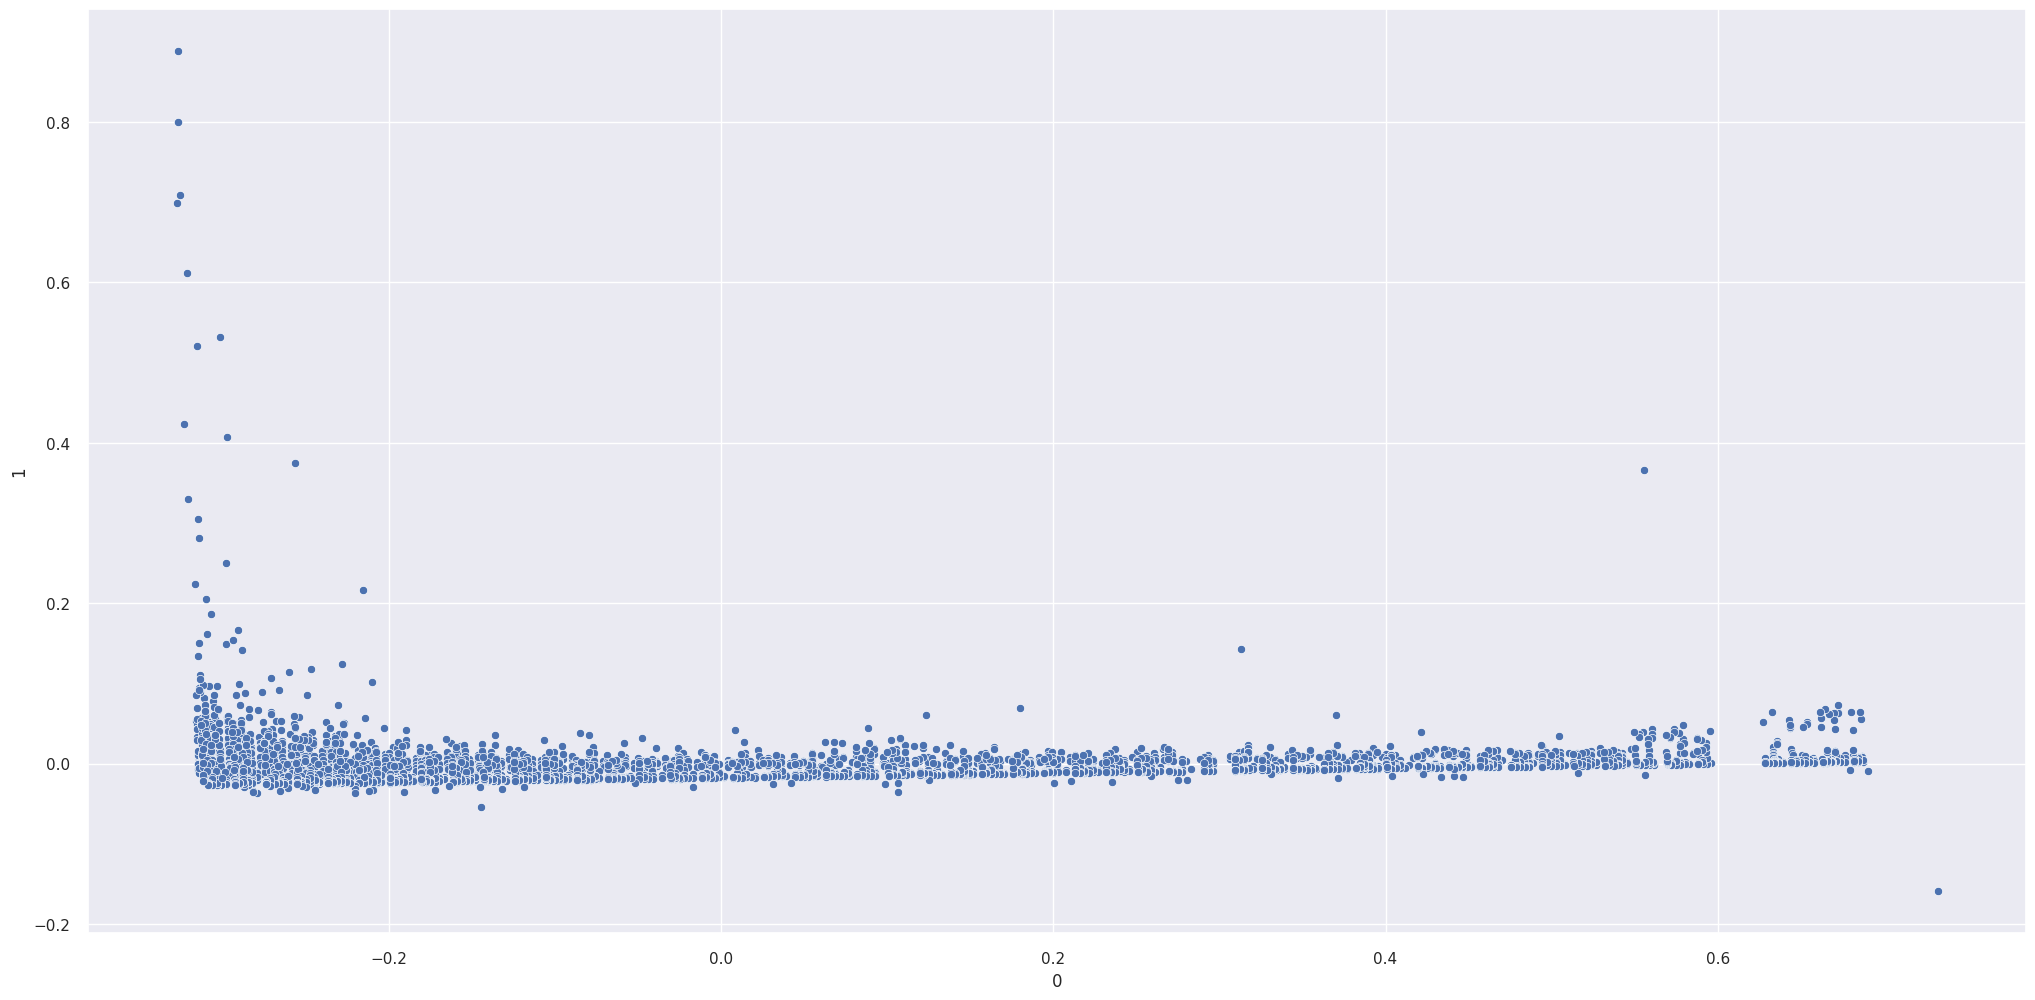

In [47]:
# creating dataframe with pca components
df_pca = pd.DataFrame( principal_components )

sns.scatterplot( x=0, y=1, data=df_pca );

### 4.3.2 UMAP

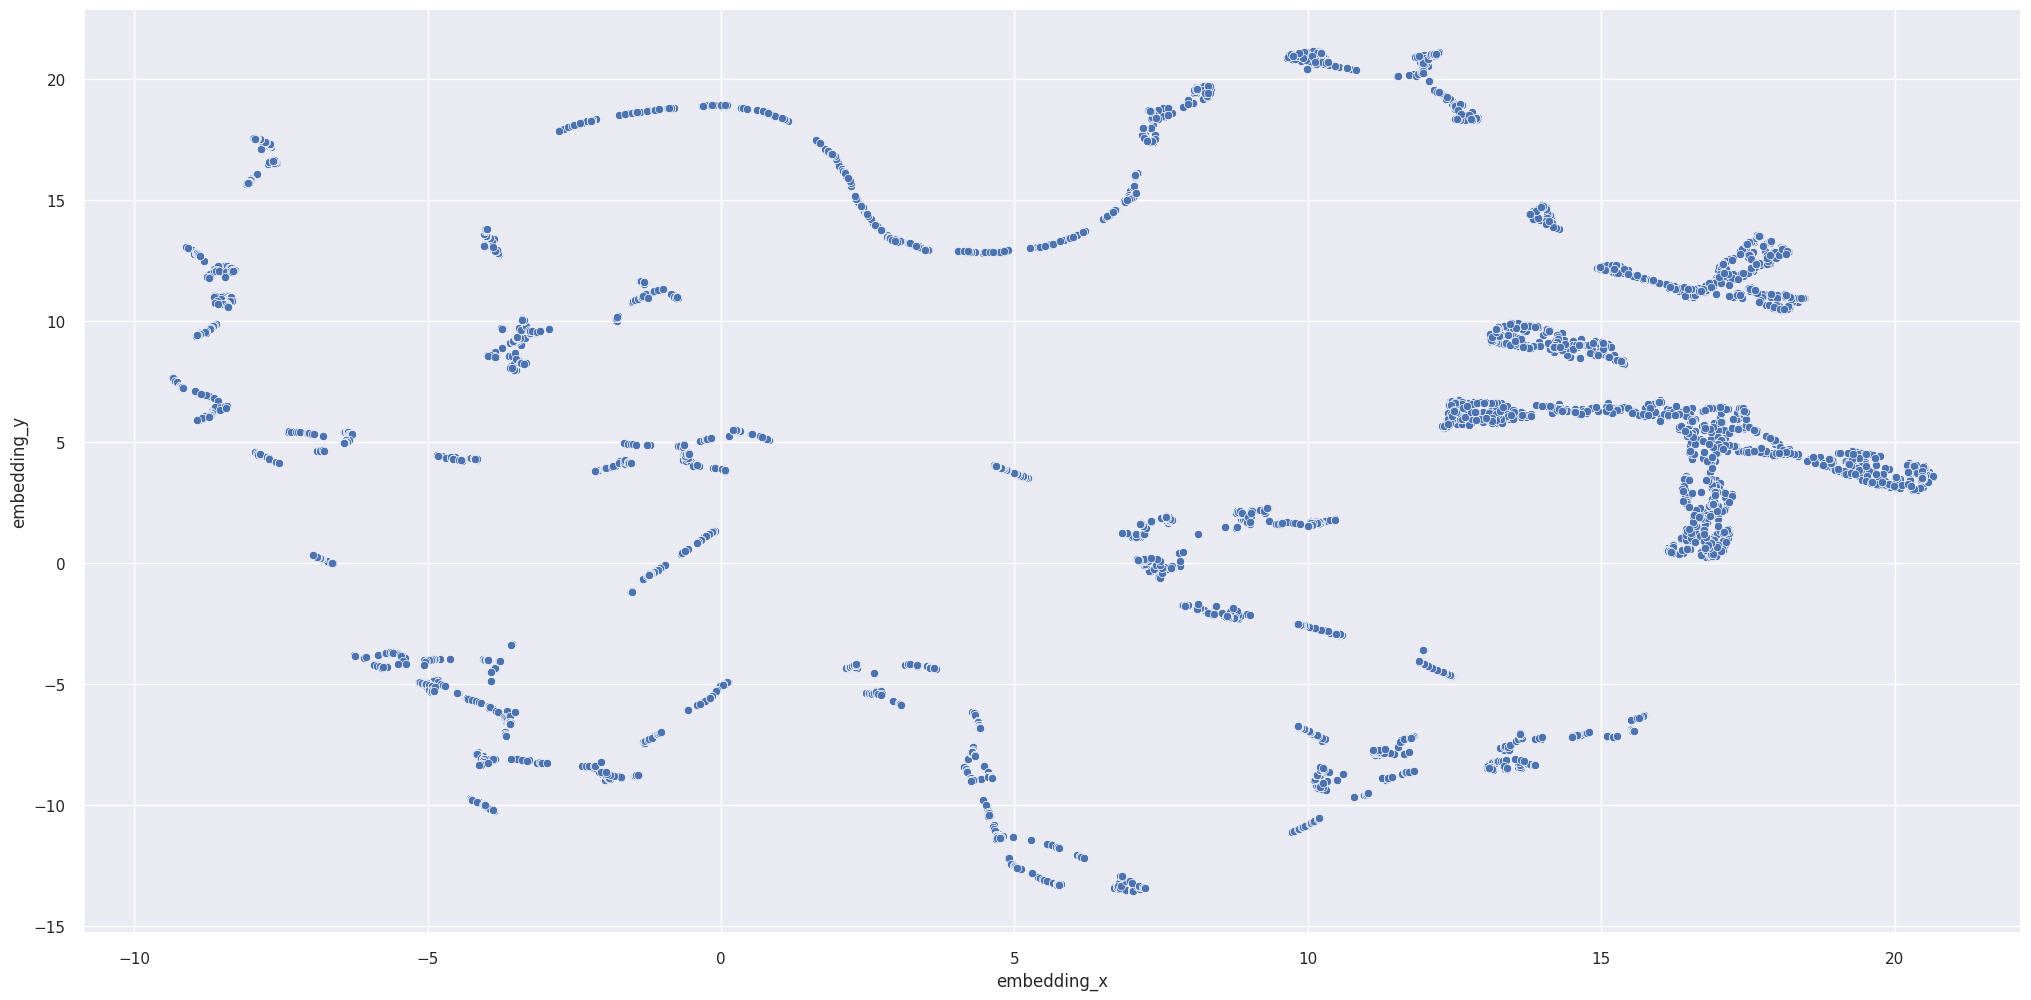

In [48]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_space )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_umap );

### 4.3.3 t-SNE

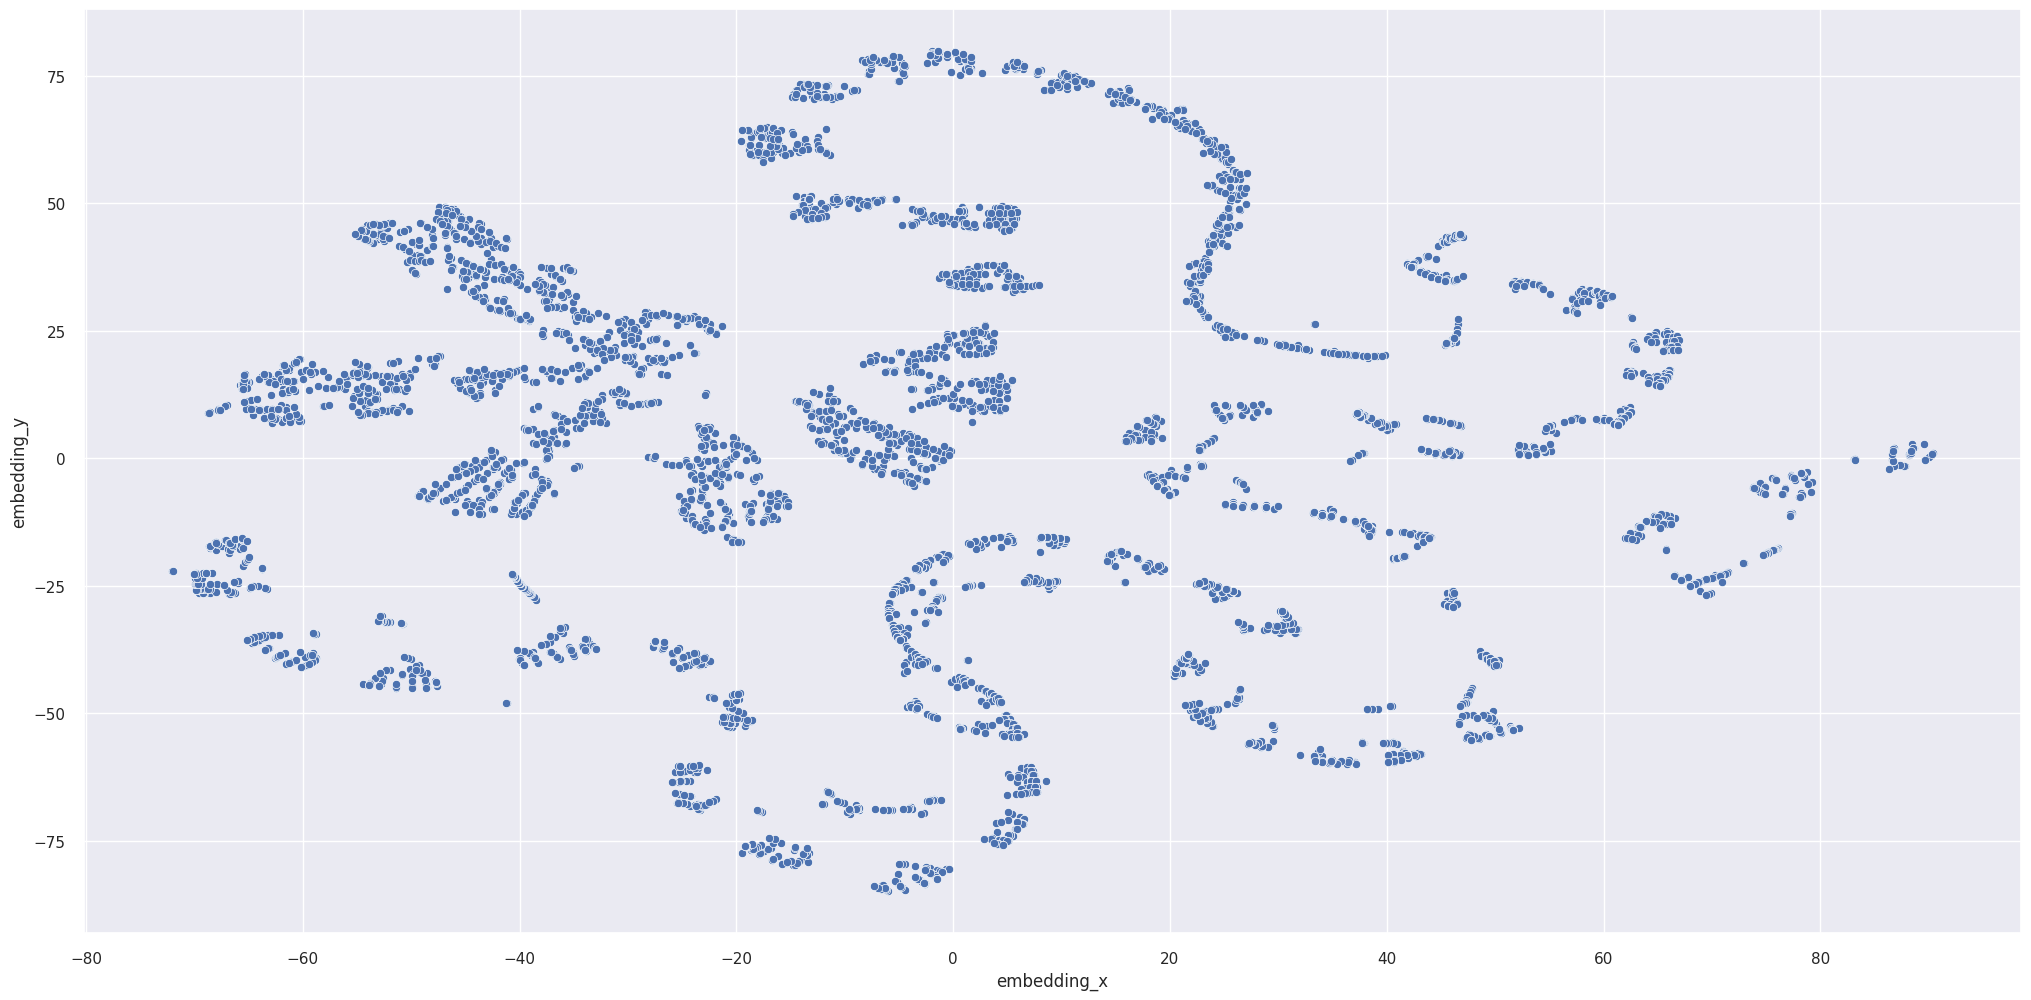

In [49]:
reducer =    TSNE( n_components=2, random_state=42, n_jobs=-1 )
embedding = reducer.fit_transform( df_space )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

# plot t-SNE
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_tsne );

### 4.4.4 Tree-Based Embedding

In [52]:

# creating X and y values for training 
X = df_space.drop( columns=['gross_revenue'], axis=1 )
y = df_space['gross_revenue']


# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# saving model
pickle.dump( rf_model, open( '../models/rf_model.pkl', 'wb' ) )

# dataframe Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,6825,6705,6461,6666,6708,6983,6596,6399,6599,6763,6934,6606,6783,6437,6714,6807,6824,6364,6886,6578,6703,6850,6566,6573,6868,6606,6928,6538,6653,6394,6578,7031,6815,6448,6510,7054,6555,6963,6739,6510,6761,6543,6573,6564,6727,6809,6509,6912,6624,6938,6556,6869,6965,6604,6667,6543,6489,6498,6857,6548,6494,6806,6445,6588,6534,6609,6945,6827,6605,6560,6908,6475,6504,6714,6496,6561,6715,6621,6829,6928,6967,6792,6482,6968,6498,6459,6683,6618,6501,6671,6817,6577,6566,6916,6567,6372,6852,6831,6607,7031
1,6219,6524,6384,6030,6464,6196,6306,6385,6521,6368,6815,6485,5791,6390,6425,6675,6295,6343,6254,6297,6477,6002,6511,6554,6206,6365,5643,6523,5716,6270,6554,6873,6372,6412,6416,6040,6121,6852,6548,6403,6220,6418,6437,6413,6436,6227,6437,6305,6426,6397,6470,6337,6823,6442,6535,6346,6376,6404,6288,6371,6371,6387,6400,6342,6399,6546,6789,6214,6284,6471,6442,5966,6501,6523,6382,6261,6236,6523,6055,6452,6815,6750,6275,6279,6389,6288,6541,6563,6349,5634,6268,6294,6428,6440,6210,6145,6232,6380,6427,6466
2,6305,6907,6439,6883,6666,6349,6587,6472,6555,6424,6872,6529,6627,5750,6644,6716,6336,6349,6089,6566,6663,6778,5611,6872,6300,6601,5781,6941,6594,6762,6523,6935,5794,5647,6807,6981,6524,6804,6786,6466,6314,6491,6592,6867,6672,6305,5385,6333,6590,5713,6666,6294,6874,6551,6616,6551,6843,6465,6802,6564,6455,6379,6449,6487,6615,6819,6870,6262,6533,6523,6822,6477,5678,6774,6469,6553,6317,6452,6893,5288,6877,6781,6467,6460,6613,6525,6606,5391,6458,6885,6346,6818,6516,6813,6560,6297,6332,6462,6848,5709
3,702,2968,863,1249,972,1009,656,694,616,654,462,790,565,587,3013,294,888,449,937,700,933,1391,810,813,1057,450,684,707,362,728,590,691,513,971,415,646,1011,860,438,831,297,651,846,674,1514,1006,826,1048,3111,371,838,526,975,519,741,652,825,851,640,246,962,309,527,897,953,702,615,707,396,3266,820,627,869,941,963,1047,945,723,605,810,862,282,322,1008,1408,875,646,350,932,682,608,602,617,713,398,415,318,875,821,604
4,951,579,417,33,528,505,932,1109,291,122,827,1116,620,755,496,639,594,539,497,85,1115,508,589,1045,1448,731,735,111,667,956,397,536,1066,572,713,528,661,549,712,940,679,1678,1652,945,528,1572,522,394,535,611,1535,856,458,1239,1034,969,385,1051,119,746,464,660,852,395,1660,985,1009,876,730,585,781,712,475,483,528,1314,39,572,336,541,158,725,673,540,44,1817,275,684,599,978,675,1170,506,1051,657,653,919,61,301,707


In [53]:
df_leaf.shape

(5696, 100)

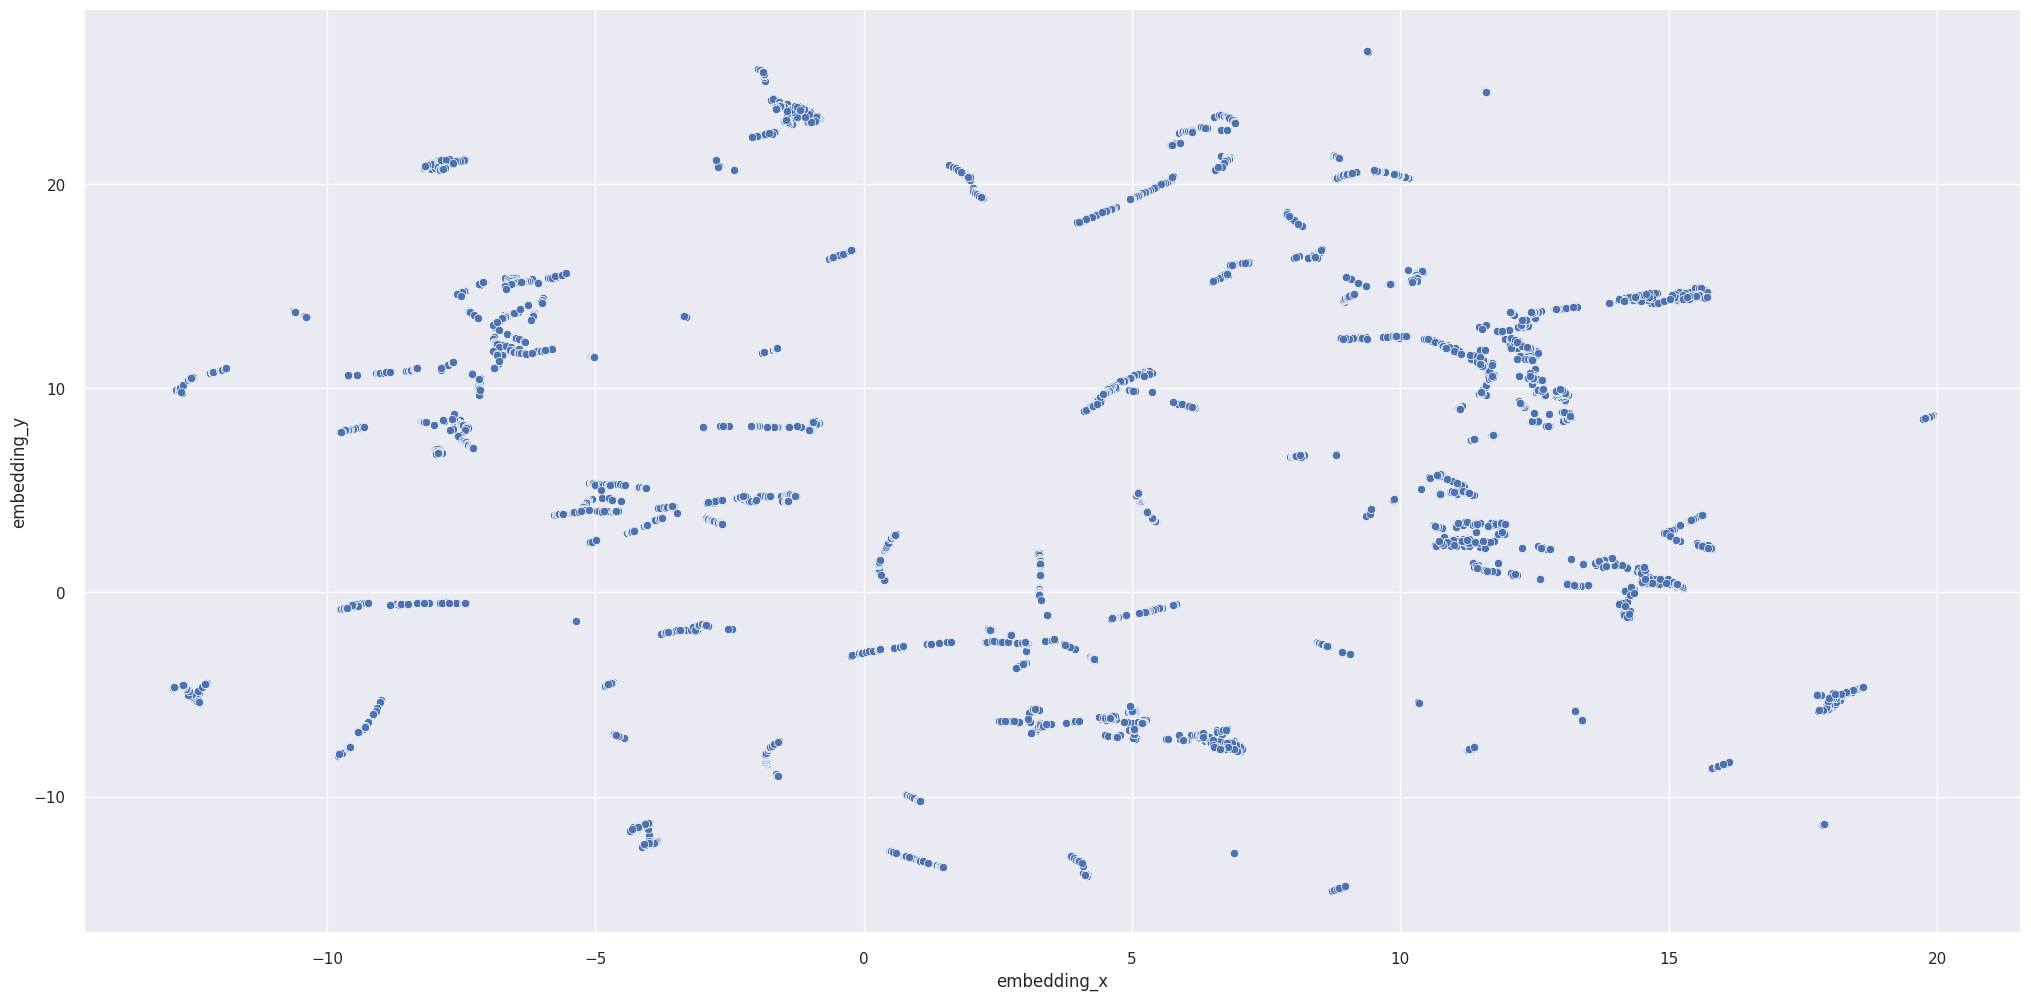

In [54]:
# reducer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

pickle.dump( reducer, open( '../parameters/umap_leaf_reducer.pkl', 'wb' ) )

# embedding on tree
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]


# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 data=df_tree );

In [79]:
pwd

'/home/datamendes/comunidadeds/projetos/insiders_clustering/notebooks'

# 7.0 Hyperparameter Fine-Tuning

In [80]:
clusters = np.arange(2, 26, 1)

# Tree Based Embedding
X = df_tree.copy()

# save Tree Based Embedding to new customers
X.to_csv('../data/tree_based_embedding.csv', index=False )

# UMAP Embedding
#X = df_umap.copy()

# t-SNE Embedding
#X = df_tsne.copy()

X.head()


,embedding_x,embedding_y
0,13.638331,1.355916
1,11.876697,3.220043
2,11.692986,2.481872
3,-3.168155,-1.704797
4,2.868047,-3.643242


## 7.1 K-Means

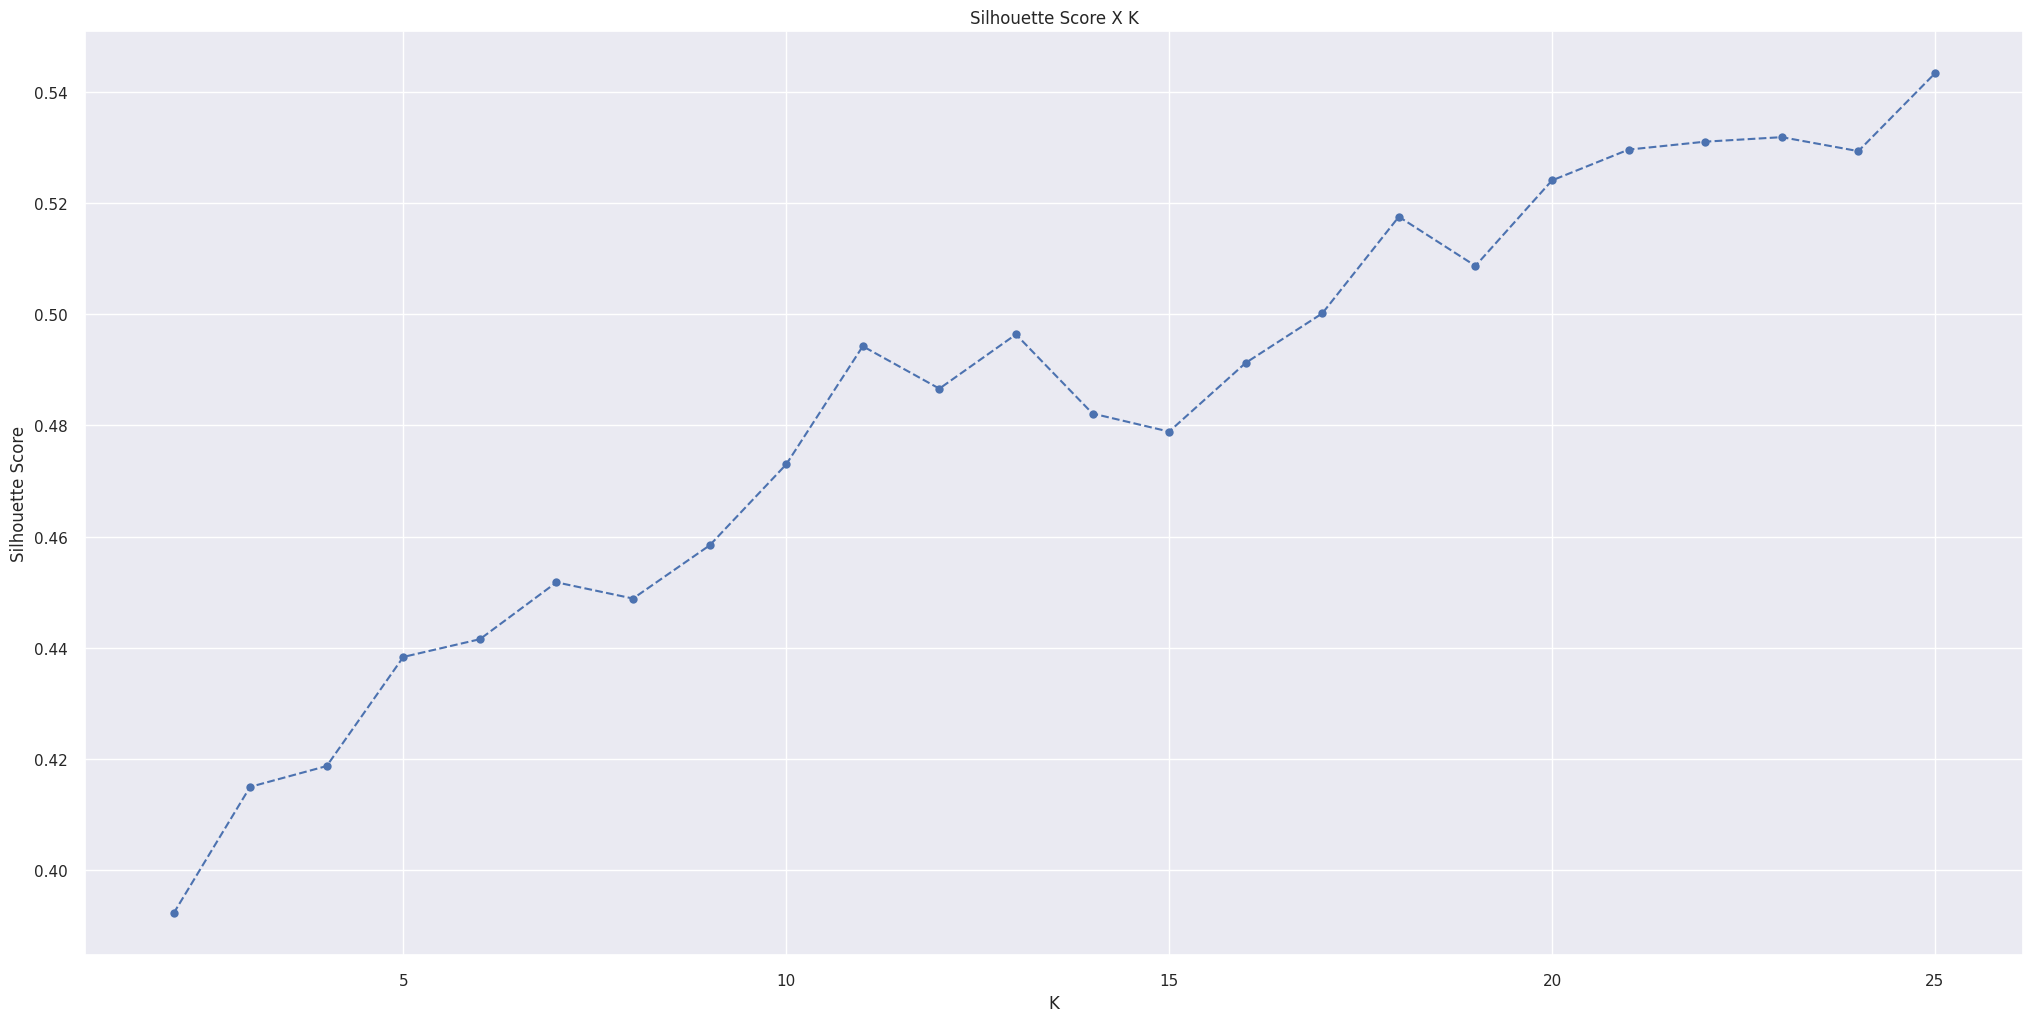

In [73]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k, n_init=100, random_state=42)
    
    # model training
    kmeans_model.fit( X )
    
    # model predict
    labels = kmeans_model.predict( X )
    
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score X K');

## 7.2 GMM

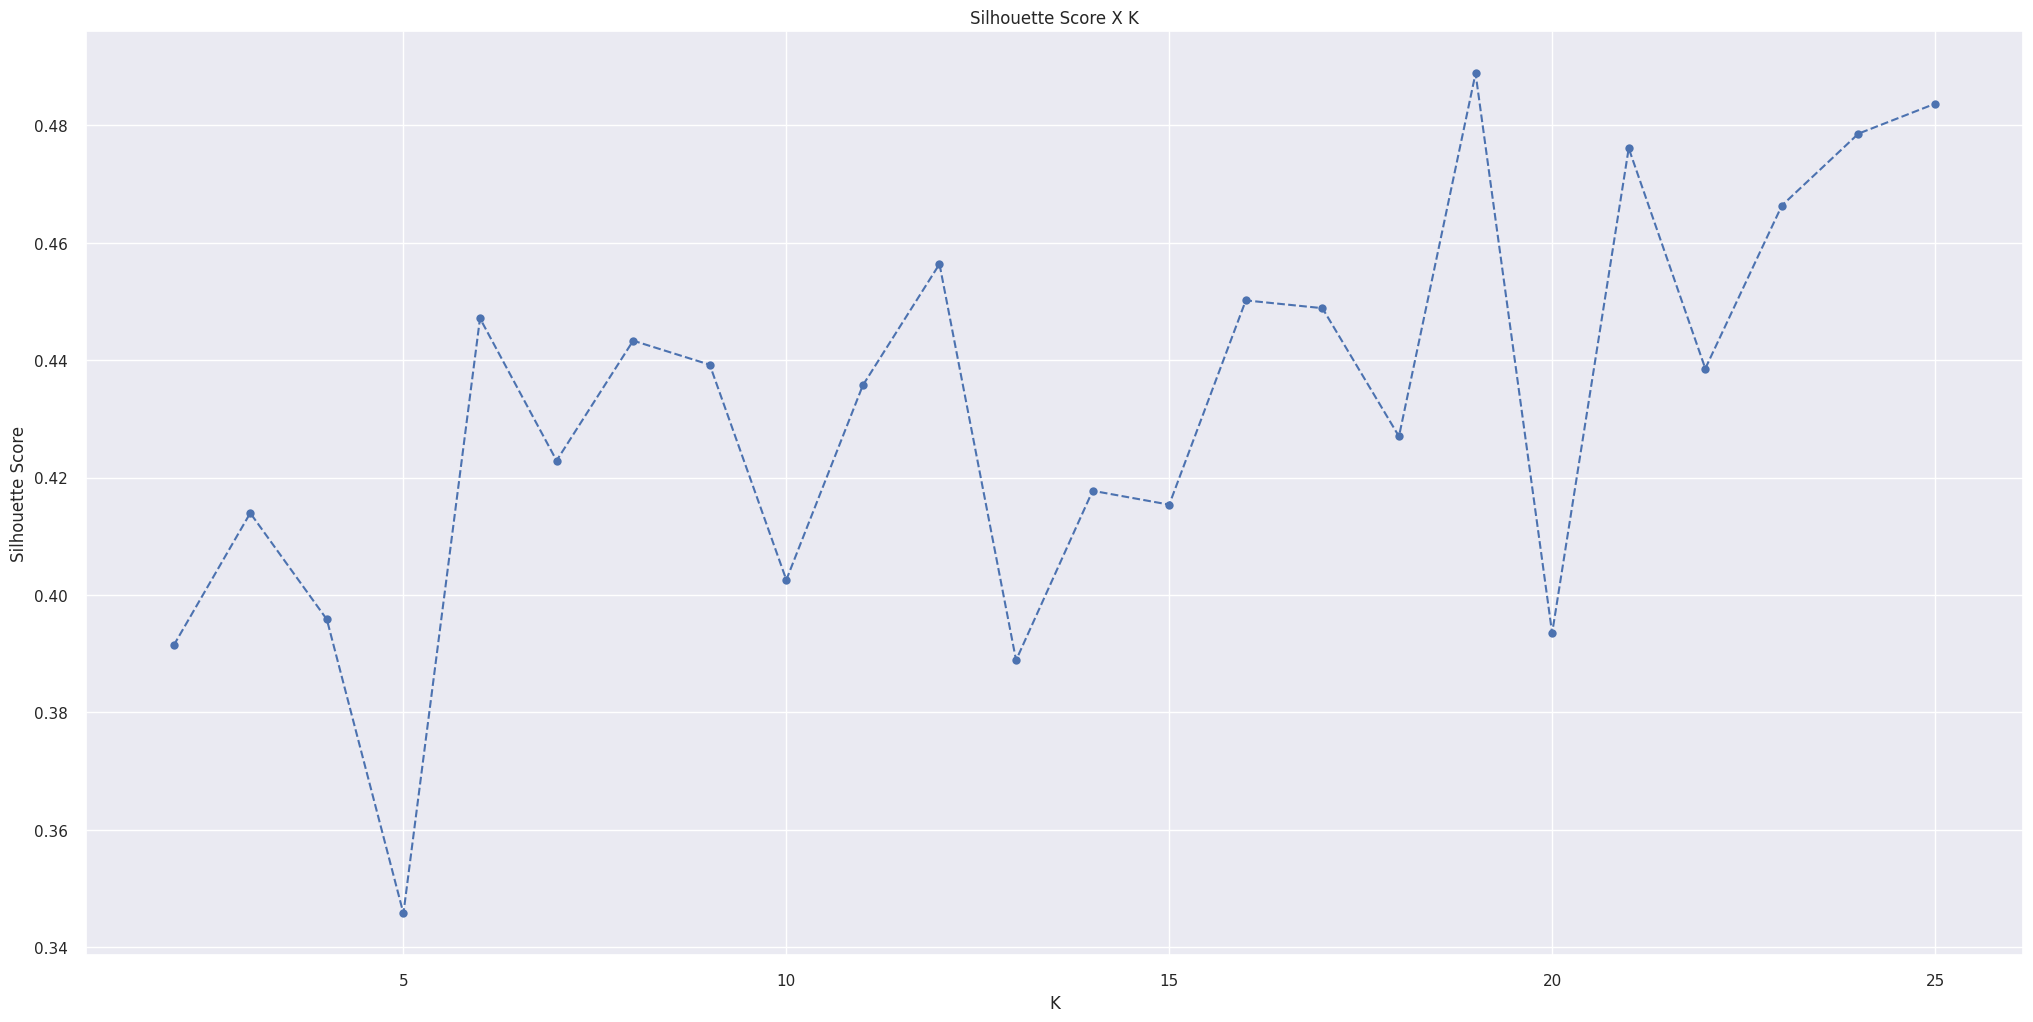

In [74]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )
    
    # model training
    gmm_model.fit( X )
    
    # model predict
    labels = gmm_model.predict( X )
    
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )


plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score X K');

## 7.3 Hierarchical Clustering

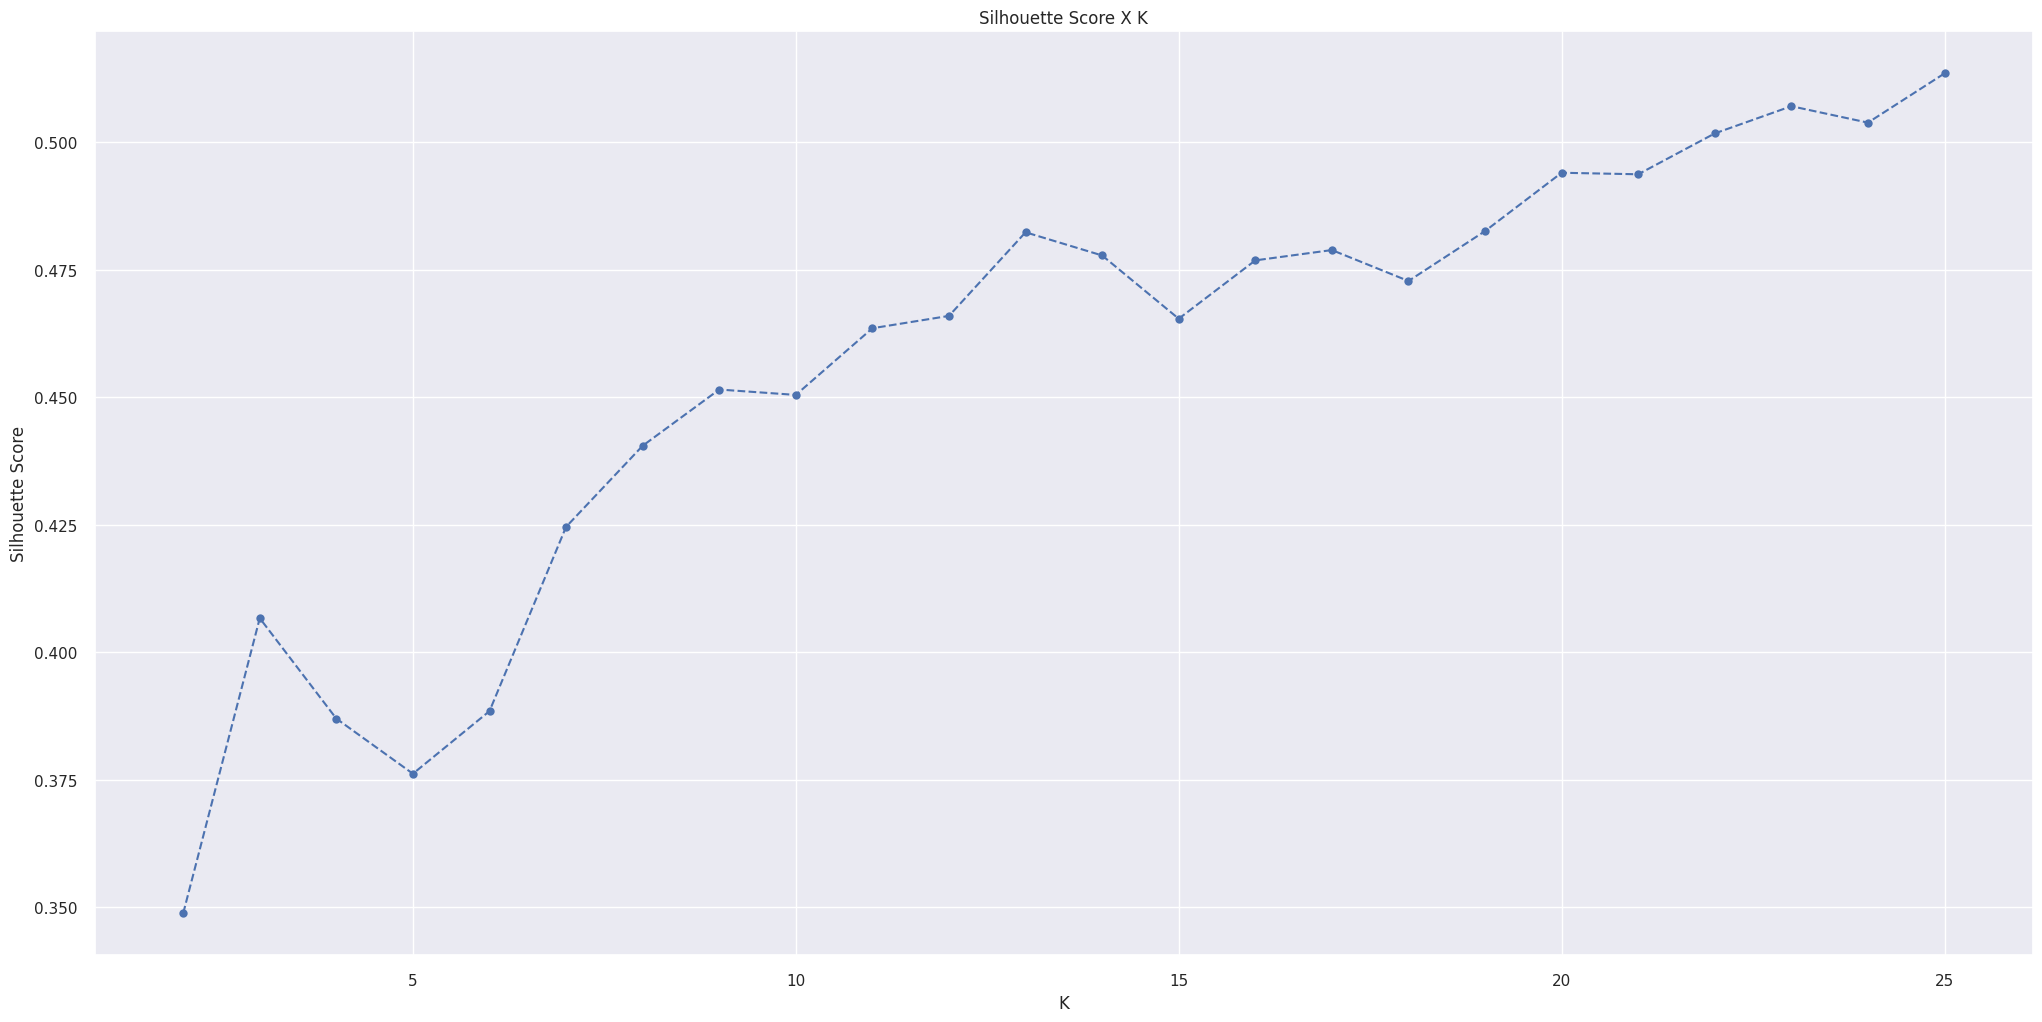

In [75]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage( X, 'ward' )
    
    # model prediction
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    
    #metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score X K');

## 7.4 DBScan

In [72]:
eps=2.10
min_samples=20

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# model training and predict
labels = dbscan_model.fit_predict( X )

# metrics
sil = m.silhouette_score( X, labels, metric='euclidean' )
print(f'Silhouette Score: {sil} ')
print( np.unique( labels ) )

dbscan_list = [ round(sil, 6), 0.000000, 0.000000, 0.000000, 0.000000, 0.000000 ]

Silhouette Score: 0.3880196511745453 
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34]


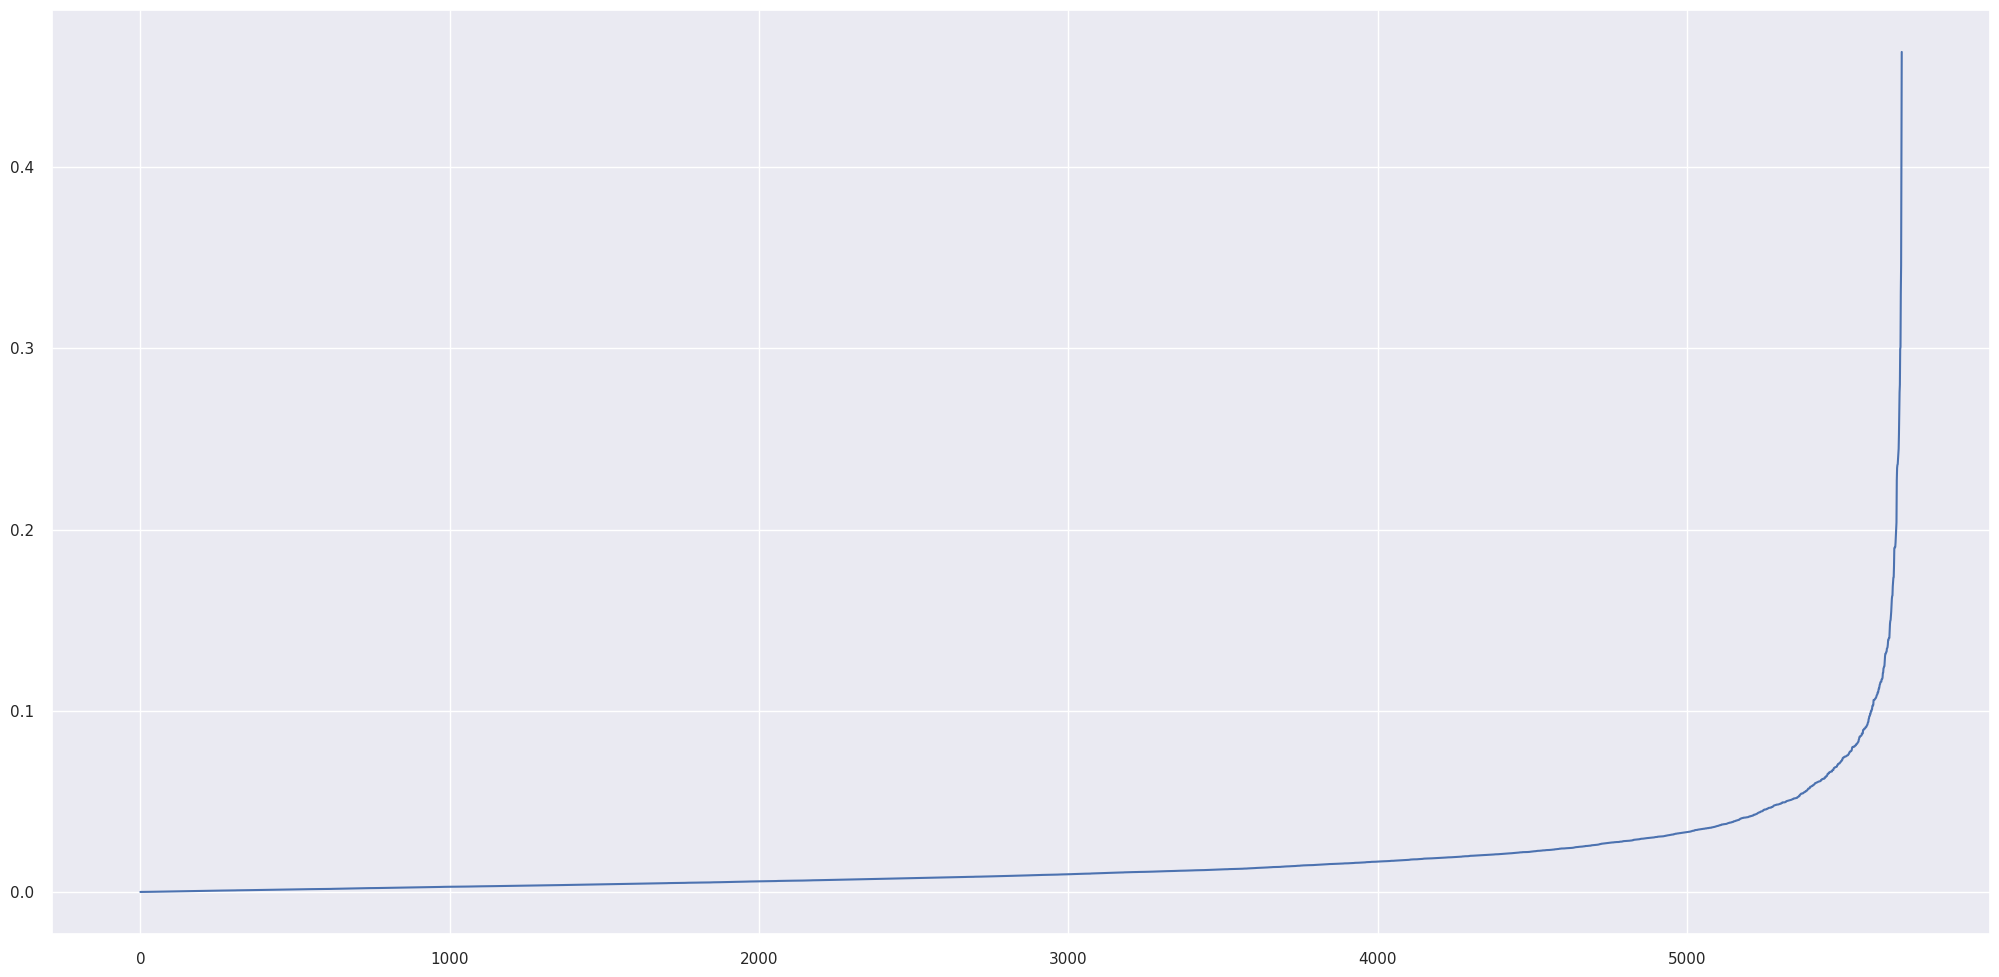

In [73]:
neighbors = NearestNeighbors( n_neighbors=min_samples).fit( X )
distances, indices = neighbors.kneighbors( X )

distances = np.sort( distances, axis=0)
distances = distances[:,1]
plt.plot( distances );

## 7.5 Modelling Result

In [76]:
df_results = pd.DataFrame( {'KMeans' : kmeans_list,
                            'GMM'    : gmm_list,
                            'HC'     : hc_list} ).T
                            #'DBSCAN' : dbscan_list } ).T
df_results.columns = clusters
df_results.head()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.392155,0.414934,0.418684,0.438324,0.441518,0.451760,0.448843,0.458413,0.472991,0.494267,0.486632,0.496397,0.482152,0.478895,0.491272,0.500180,0.517582,0.508733,0.524125,0.529672,0.531097,0.531911,0.529394,0.543392
GMM,0.391392,0.413944,0.395820,0.345716,0.447131,0.422883,0.443326,0.439227,0.402562,0.435739,0.456386,0.388867,0.417743,0.415379,0.450190,0.448866,0.427010,0.488880,0.393478,0.476114,0.438572,0.466363,0.478613,0.483712
HC,0.348754,0.406654,0.386957,0.376147,0.388428,0.424569,0.440472,0.451503,0.450447,0.463525,0.465947,0.482345,0.477798,0.465392,0.476836,0.478860,0.472788,0.482581,0.494021,0.493723,0.501740,0.507076,0.503849,0.513511


In [77]:
df_results.style.highlight_max( color='darkgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.392155,0.414934,0.418684,0.438324,0.441518,0.451760,0.448843,0.458413,0.472991,0.494267,0.486632,0.496397,0.482152,0.478895,0.491272,0.500180,0.517582,0.508733,0.524125,0.529672,0.531097,0.531911,0.529394,0.543392
GMM,0.391392,0.413944,0.395820,0.345716,0.447131,0.422883,0.443326,0.439227,0.402562,0.435739,0.456386,0.388867,0.417743,0.415379,0.450190,0.448866,0.427010,0.488880,0.393478,0.476114,0.438572,0.466363,0.478613,0.483712
HC,0.348754,0.406654,0.386957,0.376147,0.388428,0.424569,0.440472,0.451503,0.450447,0.463525,0.465947,0.482345,0.477798,0.465392,0.476836,0.478860,0.472788,0.482581,0.494021,0.493723,0.501740,0.507076,0.503849,0.513511


for K=2. Silhouette_Score: 0.3771422207355499 
for K=3. Silhouette_Score: 0.38651904463768005 
for K=4. Silhouette_Score: 0.3616310656070709 
for K=5. Silhouette_Score: 0.3725951015949249 
for K=6. Silhouette_Score: 0.3822069466114044 
for K=7. Silhouette_Score: 0.4143860340118408 
for K=8. Silhouette_Score: 0.4277665317058563 
for K=9. Silhouette_Score: 0.4467404782772064 
for K=10. Silhouette_Score: 0.4474464952945709 


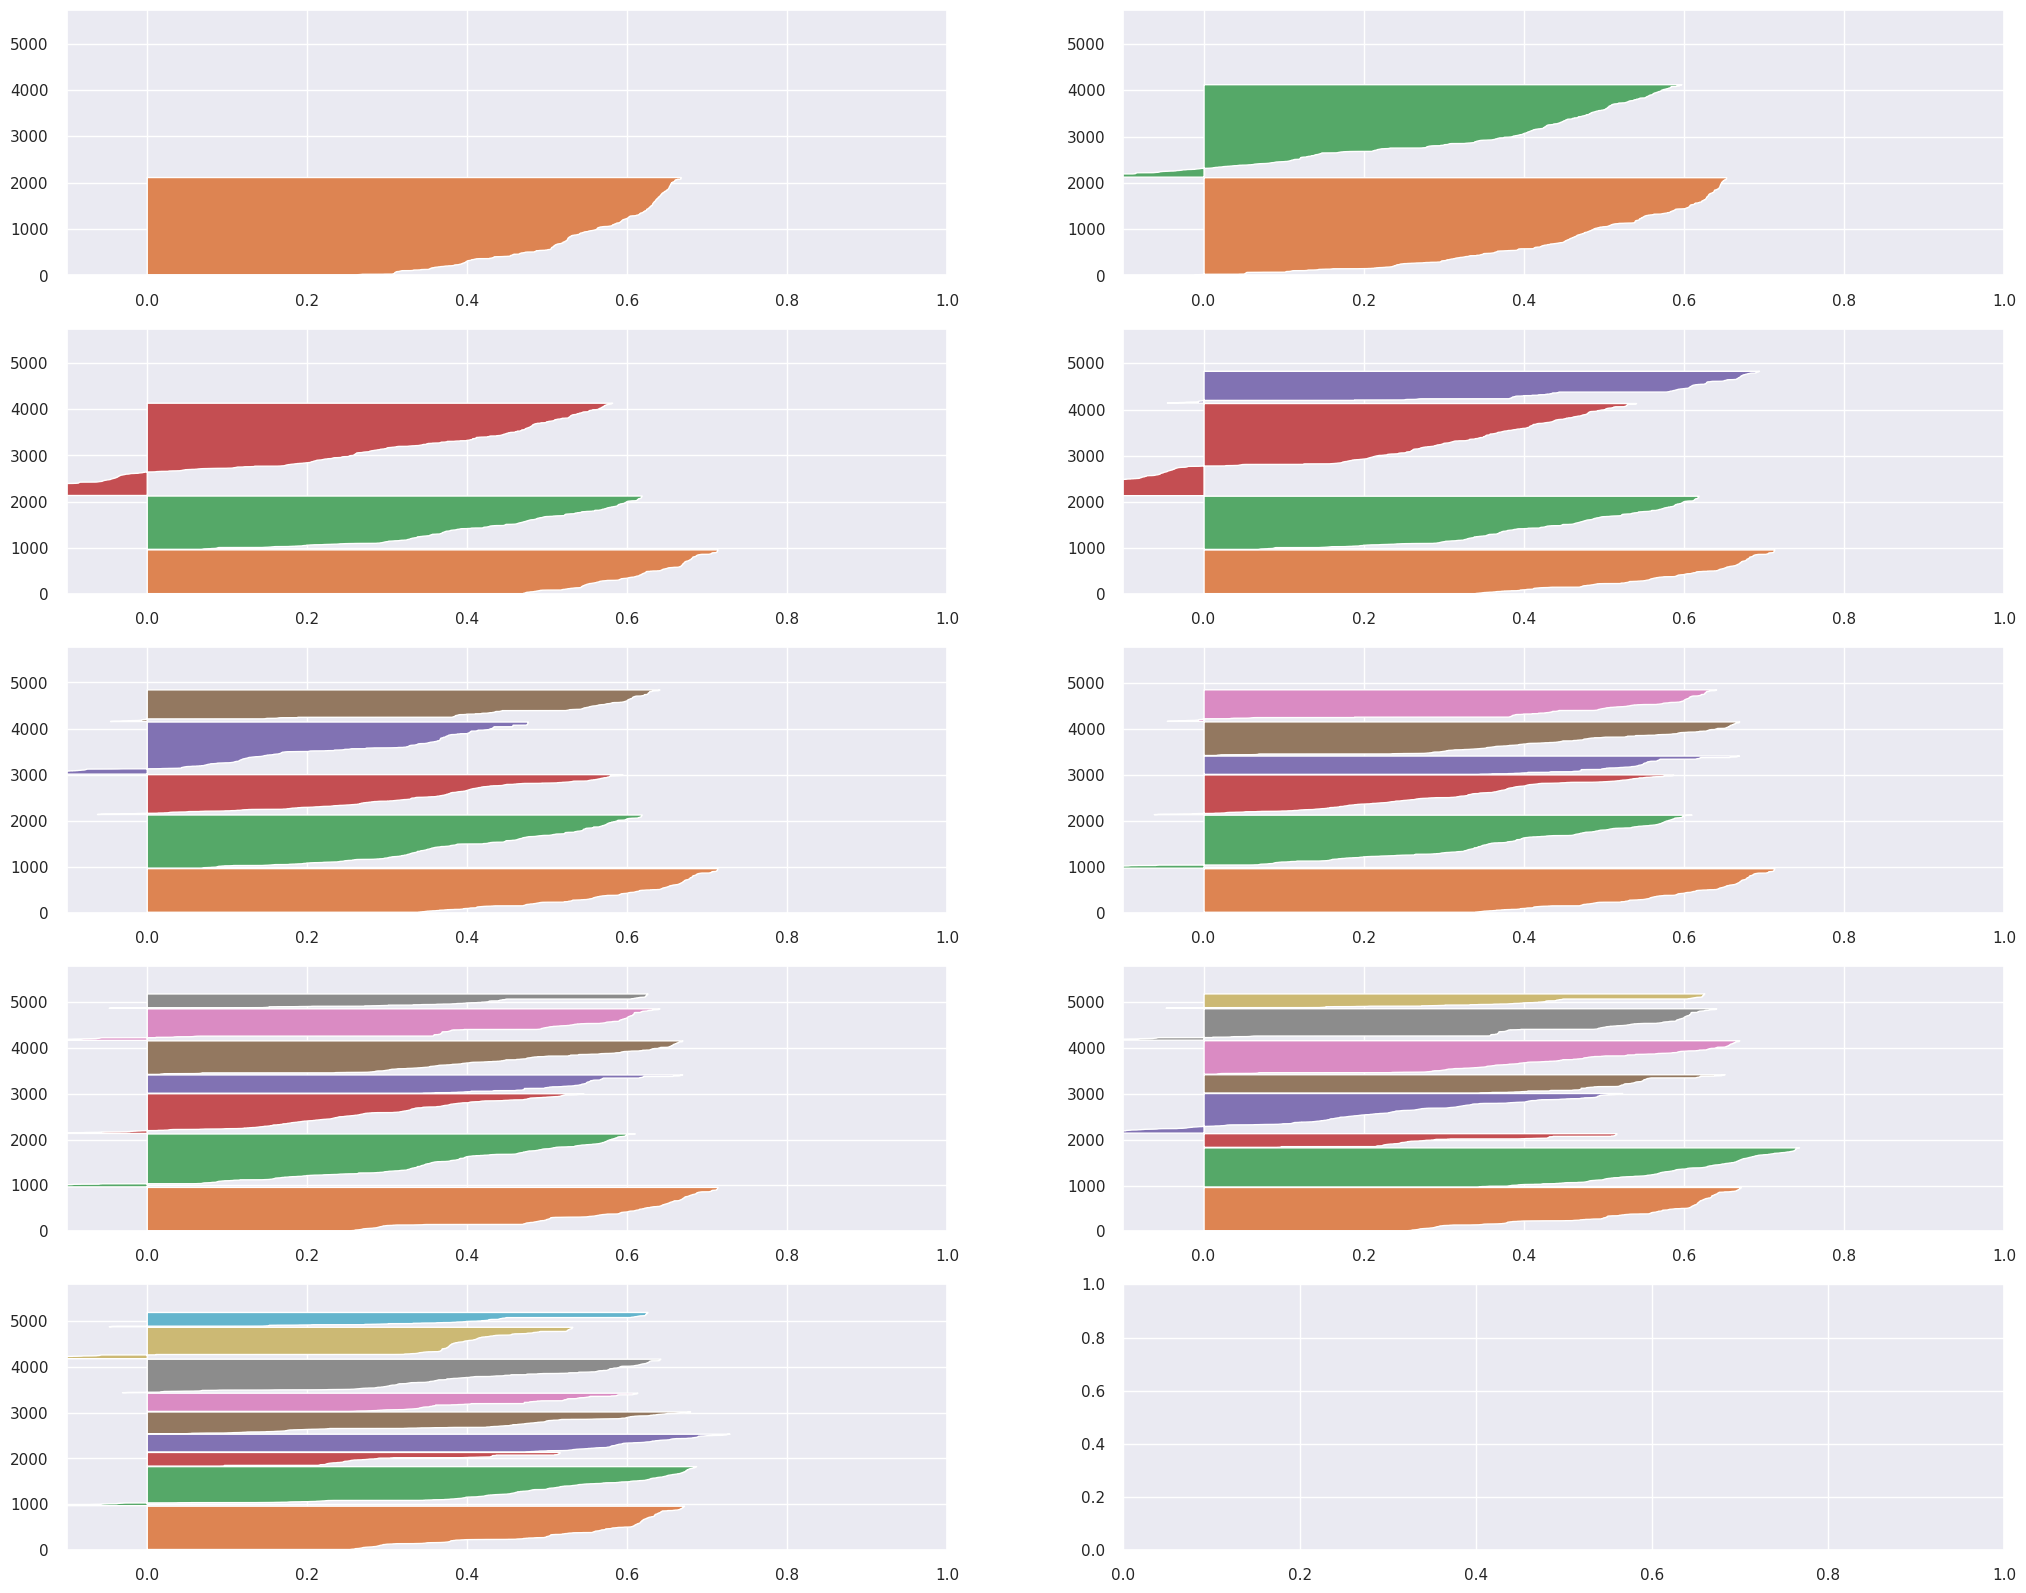

In [76]:
fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod(k, 2)
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(X) + (k+1)*10] )

    # model definition and training
    hc_model = hc.linkage( X, 'ward' )
    
    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    
    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print(f'for K={k}. Silhouette_Score: {ss} ')
    
    samples_silhouette_values = m.silhouette_samples( X, labels )
    y_lower=10

    for i in range(k):
        # select clusters
        ind_samples_silhouette_values = samples_silhouette_values[ labels==i]
                
        # size clusters
        size_cluster_i = ind_samples_silhouette_values.shape[0]
        y_upper= y_lower + size_cluster_i

        #cmap = cm.get_cmap( 'Spectral' )
        #color = cmap( i/k )
        
        # sort values
        ind_samples_silhouette_values.sort()
        
        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ind_samples_silhouette_values );
        y_lower = y_upper + 10

# 8.0 Model Training

## 8.1 Final Model : K-Means

In [77]:
# number of clusters - best silhouette score
k=10

# model definition

kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model traning
kmeans.fit( X )

# clustering
labels = kmeans.labels_


## 8.2 Cluster Validation

In [78]:
# WSS - Within Cluster Sum of Square
print(f'WSS : { kmeans.inertia_ } ' )

## SS - Silhouette Score
print(f'SS : { m.silhouette_score( X, labels, metric="euclidean" ) } ' )

WSS : 89236.140625 
SS : 0.4576358497142792 


# 9.0 Cluster Analysis

## 9.1 Cluster Visualization

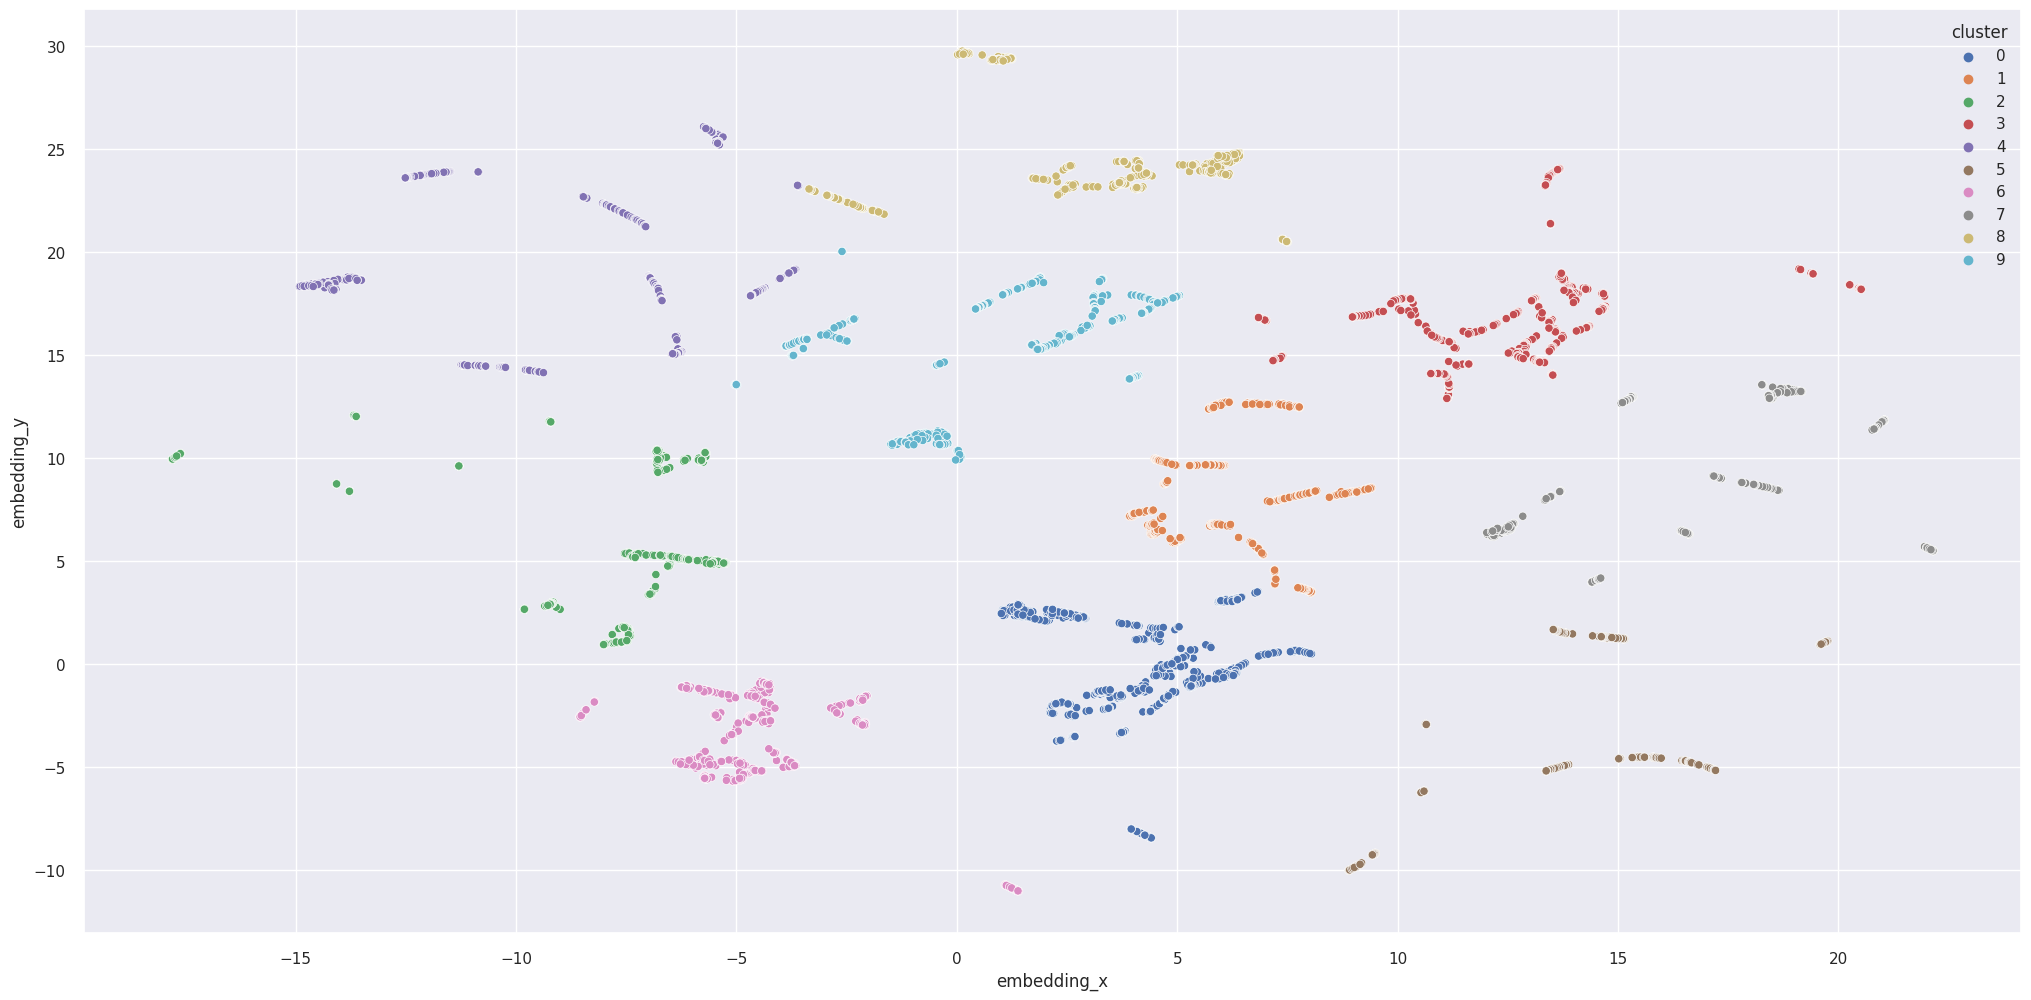

In [79]:
# data embedding
df_embedding = X.copy()
df_embedding['cluster'] = labels

sns.scatterplot( data=df_embedding, x='embedding_x', y='embedding_y', hue='cluster', palette='deep' );

## 9.2 Cluster Profile

In [86]:
df_profile = df4[cols_selected].copy()
df_profile['cluster'] = labels
df_profile.head()

,customer_id,gross_revenue,recency_days,qtt_prod_purchased,purchase_frequency,qtt_returns,cluster
0,17850.0,5391.21,372,297,17.000000,40.0,6
1,13047.0,3232.59,56,171,0.028302,35.0,6
2,12583.0,6705.38,2,232,0.040323,50.0,6
3,13748.0,948.25,95,28,0.017921,0.0,4
4,15100.0,876.00,333,3,0.073171,22.0,8


In [87]:

# Number of customer
df_cluster = df_profile[['cluster', 'customer_id']].groupby( 'cluster').count().reset_index().rename( columns = { 'customer_id' : 'count' } )
df_cluster['perc_customer'] = round( df_cluster['count'] / df_cluster['count'].sum() * 100, 2)

# Average Gross Revenue
df_cluster_gross_revenue = df_profile[['cluster', 'gross_revenue']].groupby( 'cluster').mean().reset_index()


# Average Recency Days
df_cluster_recency_days = df_profile[['cluster', 'recency_days']].groupby( 'cluster').mean().reset_index()


# Average Qtt Products Purchased
df_cluster_qtt_prod_purchased = df_profile[['cluster', 'qtt_prod_purchased']].groupby( 'cluster').mean().reset_index()


# Average Purchase Frequency
df_cluster_purchase_frequency = df_profile[['cluster', 'purchase_frequency']].groupby( 'cluster').mean().reset_index()


# Average Qtt Returns
df_cluster_qtt_returns = df_profile[['cluster', 'qtt_returns']].groupby( 'cluster').mean().reset_index()



# Average Purchase Frequeccy
#df_cluster_frequency = df9[['cluster', 'invoice_no']].groupby( 'cluster').mean().reset_index()
#df_cluster_frequency['invoice_no'] = round( df_cluster_frequency['invoice_no'], 2)

# Average Ticket
#df_cluster_ticket = df9[['cluster', 'avg_ticket']].groupby( 'cluster').mean().reset_index()
#df_cluster_ticket['avg_ticket'] = round( df_cluster_ticket['avg_ticket'], 2)

# Merging datasets
df_cluster = pd.merge( df_cluster, df_cluster_gross_revenue,      how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_recency_days,       how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_qtt_prod_purchased, how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_purchase_frequency, how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_qtt_returns,        how='inner', on='cluster' )

df_cluster.sort_values('gross_revenue', ascending=False)


,cluster,count,perc_customer,gross_revenue,recency_days,qtt_prod_purchased,purchase_frequency,qtt_returns
6,6,684,12.01,7596.064678,51.913743,361.843567,0.223634,343.625731
0,0,853,14.98,1932.700164,99.314185,120.037515,0.409327,3.769050
5,5,333,5.85,1924.481261,99.993994,45.069069,0.585119,7.945946
2,2,525,9.22,1803.543124,95.563810,142.624762,0.345457,5.041905
7,7,402,7.06,883.533930,107.746269,53.927861,0.480907,3.594527
1,1,564,9.90,721.205248,168.523050,45.274823,1.031532,4.021277
8,8,546,9.59,647.883132,99.170330,16.560440,0.149073,6.016484
9,9,648,11.38,504.869352,121.669753,20.813272,0.658849,4.314815
4,4,490,8.60,397.706776,171.169388,14.540816,0.635623,3.489796
3,3,651,11.43,312.443502,164.342550,16.539171,0.988696,6.168971


In [78]:
# define Cluster Insiders Constant
CI = 3

# 10.0 Data Analysis Exploratory - Clusters

## 10.1 Hypothesis List

### H1: Os clientes do Cluster Insiders possuem um volume(produtos) de compras acima de 10% do total de compras.
**HIPÓTESE VERDADEIRA**. O Cluster Insiders representa 50.53% de volume(produtos) de compras

In [79]:
vol_insiders = df_profile[df_profile['cluster'] == CI]['qtt_prod_purchased'].sum()
vol_clusters = df_profile['qtt_prod_purchased'].sum()

perc_vol_insiders = round( vol_insiders / vol_clusters * 100, 2)

print(f'Os clientes do Cluster Insiders possuem um volume(produtos) de { perc_vol_insiders }% do total de compras')

Os clientes do Cluster Insiders possuem um volume(produtos) de 50.53% do total de compras


### H2: Os clientes do Cluster Insiders possuem um volume(faturamento) de compras acima de 10% do total de compras.
**HIPÓTESE VERDADEIRA**. O Cluster Insiders representa 53.14% do volume total de faturamento

In [80]:
gr_insiders = df_profile[df_profile['cluster'] == CI]['gross_revenue'].sum()
gr_clusters = df_profile['gross_revenue'].sum()

perc_gr_insiders = round( gr_insiders / gr_clusters * 100, 2)

print(f'Os clientes do Cluster Insiders possuem um volume(faturamento) de { perc_gr_insiders }% do total de compras')

Os clientes do Cluster Insiders possuem um volume(faturamento) de 53.14% do total de compras


### H3: Os clientes do Cluster Insiders possuem uma média de devolução abaixo da média da base total de clientes.
**HIPÓTESE FALSA**. O Cluster Insiders possui uma média de devolução  575.53% acima da média de todos os clientes

In [81]:
avg_ret_insiders = df_profile[df_profile['cluster'] == CI]['qtt_returns'].mean()
avg_ret_clusters = df_profile['qtt_returns'].mean()

perc_ret_insiders = round( 100* ( (avg_ret_insiders / avg_ret_clusters) -1 ), 2)

print(f'Os clientes do Cluster Insiders possuem uma média de devolução { perc_ret_insiders }% acima da média de todos os clientes')

Os clientes do Cluster Insiders possuem uma média de devolução 575.53% acima da média de todos os clientes


### H4: A mediana do faturamento dos clientes do Cluster Insiders é 10% maior que a mediana do faturamento geral
**HIPÓTESE VERDADEIRA**. O Cluster Insiders possuem um faturamento 468% acima da mediana do faturamento geral

In [82]:
med_gr_insiders = df_profile[df_profile['cluster'] == CI]['gross_revenue'].median()
med_gr_clusters = df_profile['gross_revenue'].median()

perc_med_gr_insiders = round( 100* ( (med_gr_insiders / med_gr_clusters) -1 ), 2)

print(f'Os clientes do Cluster Insiders possuem uma mediana de faturamento { perc_med_gr_insiders }% acima da mediana de faturamento de todos os clientes')

Os clientes do Cluster Insiders possuem uma mediana de faturamento 468.78% acima da mediana de faturamento de todos os clientes


# 11.0 Deploy to Production

In [88]:
df_profile.dtypes

customer_id           float64
gross_revenue         float64
recency_days            int64
qtt_prod_purchased      int64
purchase_frequency    float64
qtt_returns           float64
cluster                 int32
dtype: object

## 11.1 Insert Into SQLITE

In [91]:

conn = create_engine( 'sqlite:///insiders_db.sqlite' )

In [90]:
# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id           INTEGER,
        gross_revenue         REAL,
        recency_days          INTEGER,
        qtt_prod_purchased    INTEGER
        purchase_frequency    REAL,
        qtt_returns           REAL,
        cluster               INTEGER
    )
"""

# connect dabasase
conn = sqlite3.connect( ' insiders_db.sqlite' )
conn.execute( query_create_table_insiders )
conn.commit()
conn.close()


In [92]:
# insert data

df_profile.to_sql( 'insiders', con=conn, if_exists='append', index=False )


5696

In [94]:
# select data
query_select_insiders = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query( query_select_insiders, conn )
df.shape

(5696, 7)